In [12]:
pip install folium


Note: you may need to restart the kernel to use updated packages.


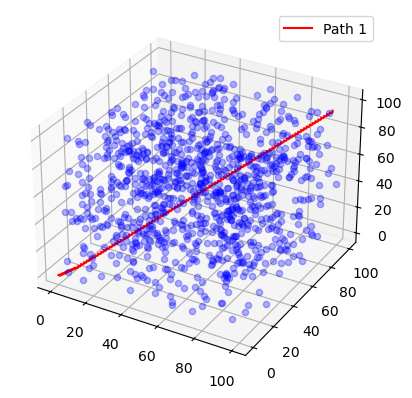

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import simpledialog
import random
from pymavlink import mavutil
import math
import folium
from folium.plugins import MarkerCluster

# PROBLEM 1: 3D GRID SHORTEST PATH WITH GUI

def create_3d_grid(size, weight_points=10):
    """Creates a 3D grid with weights."""
    grid = np.zeros((size, size, size))
    random_points = random.sample(range(size**3), k=size * weight_points)
    for point in random_points:
        x, y, z = np.unravel_index(point, (size, size, size))
        grid[x, y, z] = random.randint(1, 10)
    return grid

def heuristic(a, b):
    """Heuristic function for A* algorithm."""
    return np.linalg.norm(np.array(a) - np.array(b))

def shortest_path_3d(grid, start, end, velocity, occupied_times):
    """Finds shortest path using A* algorithm, avoiding time conflicts."""
    size = grid.shape[0]
    G = nx.grid_graph(dim=[size, size, size])

    # Assign weights to edges
    for (x, y, z) in G.nodes:
        G.nodes[(x, y, z)]['weight'] = grid[x, y, z] if grid[x, y, z] > 0 else 1

    def weight(u, v, data):
        return (G.nodes[u]['weight'] + G.nodes[v]['weight']) / 2

    try:
        path = nx.astar_path(G, start, end, heuristic=heuristic, weight=weight)
        time = 0
        for i in range(1, len(path)):
            time += 1 / velocity
            if path[i] in occupied_times and time in occupied_times[path[i]]:
                print(f"Conflict at {path[i]} at time {time:.2f}s")
                return []
            occupied_times.setdefault(path[i], []).append(time)
        return path
    except nx.NetworkXNoPath:
        print(f"No path found from {start} to {end}.")
        return []

def plot_paths_3d(grid, paths):
    """Plots paths in 3D."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    size = grid.shape[0]
    for x in range(size):
        for y in range(size):
            for z in range(size):
                if grid[x, y, z] > 0:
                    ax.scatter(x, y, z, c='b', alpha=0.3)

    colors = ['r', 'g', 'c', 'm']
    for i, path in enumerate(paths):
        if path:
            xs, ys, zs = zip(*path)
            ax.plot(xs, ys, zs, color=colors[i % len(colors)], label=f'Path {i + 1}')

    plt.legend()
    return fig

# PROBLEM 2: WAYPOINT MISSION PLANNING

def generate_waypoints():
    """Generate waypoints."""
    base_lat, base_lon = 37.7749, -122.4194
    altitude = 10
    waypoints = [{'lat': base_lat + 0.001 * i, 'lon': base_lon + 0.001 * i, 'alt': altitude + i} for i in range(15)]
    return waypoints

def add_perpendicular_waypoint(waypoints):
    """Add a perpendicular waypoint."""
    lat, lon, alt = waypoints[9]['lat'], waypoints[9]['lon'], waypoints[9]['alt']
    new_waypoint = {'lat': lat + 0.001, 'lon': lon - 0.001, 'alt': alt}
    waypoints.insert(10, new_waypoint)
    return waypoints

def plot_waypoints_map(waypoints, trajectory=None):
    """Plots waypoints on a map."""
    m = folium.Map(location=[waypoints[0]['lat'], waypoints[0]['lon']], zoom_start=13)
    marker_cluster = MarkerCluster().add_to(m)
    for i, wp in enumerate(waypoints):
        folium.Marker([wp['lat'], wp['lon']], popup=f"Waypoint {i + 1}").add_to(marker_cluster)

    if trajectory:
        folium.PolyLine([(lat, lon) for lat, lon in trajectory], color='blue').add_to(m)

    m.save("mission_map.html")
    print("Map saved to mission_map.html")
    return m

# GUI Implementation for Problem 1

def run_gui():
    root = tk.Tk()
    root.title("3D Grid Pathfinding")

    def generate_paths():
        size = int(size_entry.get())
        velocity = float(velocity_entry.get())
        grid = create_3d_grid(size)
        start = tuple(map(int, start_entry.get().split(',')))
        end = tuple(map(int, end_entry.get().split(',')))

        occupied_times = {}
        path = shortest_path_3d(grid, start, end, velocity, occupied_times)
        fig = plot_paths_3d(grid, [path])

        canvas = FigureCanvasTkAgg(fig, master=root)
        canvas.draw()
        canvas.get_tk_widget().pack()

    tk.Label(root, text="Grid Size:").pack()
    size_entry = tk.Entry(root)
    size_entry.insert(0, "101")
    size_entry.pack()

    tk.Label(root, text="Velocity (m/s):").pack()
    velocity_entry = tk.Entry(root)
    velocity_entry.insert(0, "1")
    velocity_entry.pack()

    tk.Label(root, text="Start Point (x,y,z):").pack()
    start_entry = tk.Entry(root)
    start_entry.insert(0, "0,0,0")
    start_entry.pack()

    tk.Label(root, text="End Point (x,y,z):").pack()
    end_entry = tk.Entry(root)
    end_entry.insert(0, "100,100,100")
    end_entry.pack()

    tk.Button(root, text="Generate Path", command=generate_paths).pack()

    root.mainloop()

if __name__ == "__main__":
    run_gui()

